<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-и-обзор-данных" data-toc-modified-id="Подготовка-и-обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка и обзор данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Bert" data-toc-modified-id="Bert-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bert</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Перед нами стоит задача классификации. Необходимо обучить модель, которая по тексту в вакансии будет определять формат работы - удаленный, или нет.

In [56]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import notebook 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
import functools
import xgboost as xgb
import optuna
import torch
from transformers import AutoTokenizer, AutoModel, BertModel, BertConfig

## Подготовка и обзор данных

In [2]:
data = pd.read_csv('C:/Users/User/Desktop/123/test.csv')
data.head()

,ID,Найдено в,Текст,Удаленка
0,67259437,Описание,Желание работать на всесезонной базе отдыха кл...,0
1,67542900,Описание,"График работы: 5/2, возможна удаленная работа ...",1
2,66953697,Описание,6.Ежедневная проверка классных и домашних рабо...,0
3,67381114,Описание,Работа РЯДОМ С ДОМОМ,-1
4,67624820,Описание,Удаленная работа,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1368 non-null   int64 
 1   Найдено в  1368 non-null   object
 2   Текст      1368 non-null   object
 3   Удаленка   1368 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 42.9+ KB


<AxesSubplot:>

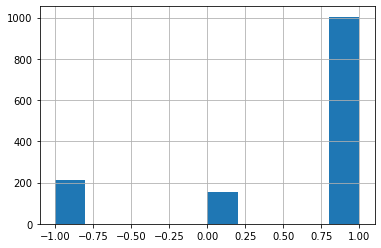

In [4]:
data['Удаленка'].hist()

Есть дисбаланс классов

In [5]:
data.duplicated().sum()

0

Датафрейм содержит три столбца:
- ID - id вакансии в базе
- Найдено в - столбец, который отображает где найдена информация об удаленной работе, в описании или названии вакансии
- Текст - информация в вакансии. Текс, с котором нам предстоит работать
- Удаленка - разметка данных, которая отображает удаленная работа описана в вакансии или нет.

В данных нет пропусков, и нет дубликатов. В таблице 1368 записей. 

Переименуем столбцы

In [6]:
data.columns=['id', 'found_in', 'text', 'remote']

Для дальнейшей работы нам необходимы только два столбца text и remote.

In [7]:
data = data[['text', 'remote']]
data.head()

,text,remote
0,Желание работать на всесезонной базе отдыха кл...,0
1,"График работы: 5/2, возможна удаленная работа ...",1
2,6.Ежедневная проверка классных и домашних рабо...,0
3,Работа РЯДОМ С ДОМОМ,-1
4,Удаленная работа,1


Текст, с которым будем работать, на русском языке. Поэтому для его лемматизации будем использовать библиотеку pymystem3. Лемматизируем наш текс, и сразу удалим из него лишние символы.

In [8]:
m = Mystem()
for i in notebook.tqdm(range(len(data['text']))):
    lemm_list = m.lemmatize(data['text'][i])
    data['text'][i] = " ".join(lemm_list)
    a = re.sub(r'[^а-яА-ЯёЁ ]', ' ', data['text'][i])
    data['text'][i] = ' '.join(a.split())

  0%|          | 0/1368 [00:00<?, ?it/s]

C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
data.head()

,text,remote
0,желание работать на всесезонный база отдых клу...,0
1,график работа возможный удаленный работа техни...,1
2,ежедневный проверка классный и домашний работа...,0
3,работа рядом с дом,-1
4,удаленный работа,1


In [10]:
features = data['text']
target = data['remote']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=148)

In [11]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('russian'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение модели

### LogisticRegression

In [12]:
%time
model_l_r = LogisticRegression(solver="saga", max_iter=1000)
model_l_r.fit(features_train, target_train)
p = model_l_r.predict(features_test)
print('F1:', f1_score(target_test, p, average='weighted'))
print('Accuracy:', accuracy_score(target_test, p))

Wall time: 0 ns
F1: 0.8679400721498837
Accuracy: 0.8795620437956204


### RandomForest

In [13]:
%time
model_f = RandomForestClassifier(class_weight='balanced')
model_f.fit(features_train, target_train)
p = model_f.predict(features_test)
print('F1:', f1_score(target_test, p, average='weighted'))
print('Accuracy:', accuracy_score(target_test, p))

Wall time: 0 ns
F1: 0.8828411641194595
Accuracy: 0.8905109489051095


### DecisionTree

In [14]:
%time
model_t = DecisionTreeClassifier(class_weight='balanced')
model_t.fit(features_train, target_train)
p = model_t.predict(features_test)
print('F1:', f1_score(target_test, p, average='weighted'))
print('Accuracy:', accuracy_score(target_test, p))

Wall time: 0 ns
F1: 0.8640796268206662
Accuracy: 0.864963503649635


### XGBoost

In [15]:
def opt(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    #learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.1, 0.01)
    #scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_tuna = xgb.XGBClassifier(
        random_state=148,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        #learning_rate = learning_rate,
        #scale_pos_weight = scale_pos_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_test)
    
    return (accuracy_score(y_test, tuna_pred_test))

In [16]:
study = optuna.create_study()
study.optimize(functools.partial(opt, features_train, target_train, features_test, target_test), n_trials=100)

[I 2022-07-30 19:55:17,245] A new study created in memory with name: no-name-b33ea51d-03f8-4c2a-a691-9be3e1938075


[19:55:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-07-30 19:55:19,492] Trial 0 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 975, 'max_depth': 14, 'min_child_weight': 12, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[19:55:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:19,873] Trial 1 finished with value: 0.8686131386861314 and parameters: {'n_estimators': 218, 'max_depth': 1, 'min_child_weight': 18, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:20,324] Trial 2 finished with value: 0.8868613138686131 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:21,127] Trial 3 finished with value: 0.8613138686131386 and parameters: {'n_estimators': 397, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:21,950] Trial 4 finished with value: 0.8759124087591241 and parameters: {'n_estimators': 145, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:23,486] Trial 5 finished with value: 0.8759124087591241 and parameters: {'n_estimators': 409, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:24,061] Trial 6 finished with value: 0.8686131386861314 and parameters: {'n_estimators': 340, 'max_depth': 1, 'min_child_weight': 11, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:25,131] Trial 7 finished with value: 0.864963503649635 and parameters: {'n_estimators': 489, 'max_depth': 16, 'min_child_weight': 16, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:27,228] Trial 8 finished with value: 0.8832116788321168 and parameters: {'n_estimators': 844, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:27,494] Trial 9 finished with value: 0.8759124087591241 and parameters: {'n_estimators': 81, 'max_depth': 11, 'min_child_weight': 18, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.8394160583941606.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:29,871] Trial 10 finished with value: 0.8284671532846716 and parameters: {'n_estimators': 958, 'max_depth': 14, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:32,348] Trial 11 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 989, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:34,328] Trial 12 finished with value: 0.8613138686131386 and parameters: {'n_estimators': 736, 'max_depth': 20, 'min_child_weight': 8, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:36,123] Trial 13 finished with value: 0.8540145985401459 and parameters: {'n_estimators': 677, 'max_depth': 14, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:38,576] Trial 14 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 985, 'max_depth': 9, 'min_child_weight': 14, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:40,311] Trial 15 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 635, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:42,553] Trial 16 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 833, 'max_depth': 20, 'min_child_weight': 6, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:44,448] Trial 17 finished with value: 0.8540145985401459 and parameters: {'n_estimators': 854, 'max_depth': 9, 'min_child_weight': 13, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:46,676] Trial 18 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 921, 'max_depth': 13, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:48,405] Trial 19 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 746, 'max_depth': 16, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:50,097] Trial 20 finished with value: 0.8613138686131386 and parameters: {'n_estimators': 570, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:52,345] Trial 21 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 973, 'max_depth': 14, 'min_child_weight': 12, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:54,590] Trial 22 finished with value: 0.8357664233576643 and parameters: {'n_estimators': 1000, 'max_depth': 18, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:56,599] Trial 23 finished with value: 0.8357664233576643 and parameters: {'n_estimators': 889, 'max_depth': 18, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:55:58,480] Trial 24 finished with value: 0.8686131386861314 and parameters: {'n_estimators': 746, 'max_depth': 18, 'min_child_weight': 9, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:00,421] Trial 25 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 802, 'max_depth': 16, 'min_child_weight': 14, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:02,402] Trial 26 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 899, 'max_depth': 17, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:04,430] Trial 27 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 899, 'max_depth': 12, 'min_child_weight': 17, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:06,193] Trial 28 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 784, 'max_depth': 15, 'min_child_weight': 20, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:08,581] Trial 29 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 927, 'max_depth': 14, 'min_child_weight': 9, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:10,102] Trial 30 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 610, 'max_depth': 11, 'min_child_weight': 12, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:12,133] Trial 31 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 902, 'max_depth': 18, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:14,221] Trial 32 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 892, 'max_depth': 19, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:16,521] Trial 33 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 965, 'max_depth': 17, 'min_child_weight': 11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:17,958] Trial 34 finished with value: 0.8613138686131386 and parameters: {'n_estimators': 702, 'max_depth': 15, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:19,779] Trial 35 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 810, 'max_depth': 17, 'min_child_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:21,894] Trial 36 finished with value: 0.8357664233576643 and parameters: {'n_estimators': 877, 'max_depth': 13, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:22,742] Trial 37 finished with value: 0.8795620437956204 and parameters: {'n_estimators': 299, 'max_depth': 13, 'min_child_weight': 18, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:24,780] Trial 38 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 940, 'max_depth': 19, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:26,585] Trial 39 finished with value: 0.864963503649635 and parameters: {'n_estimators': 522, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-07-30 19:56:26,731] Trial 40 finished with value: 0.8759124087591241 and parameters: {'n_estimators': 30, 'max_depth': 10, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\pr

[19:56:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:28,774] Trial 41 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 879, 'max_depth': 17, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:30,691] Trial 42 finished with value: 0.843065693430657 and parameters: {'n_estimators': 849, 'max_depth': 15, 'min_child_weight': 19, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:33,442] Trial 43 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 12, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:35,492] Trial 44 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 946, 'max_depth': 15, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:37,741] Trial 45 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 997, 'max_depth': 4, 'min_child_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:39,342] Trial 46 finished with value: 0.8686131386861314 and parameters: {'n_estimators': 784, 'max_depth': 2, 'min_child_weight': 11, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:39,973] Trial 47 finished with value: 0.8686131386861314 and parameters: {'n_estimators': 233, 'max_depth': 7, 'min_child_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:41,013] Trial 48 finished with value: 0.8540145985401459 and parameters: {'n_estimators': 446, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:43,258] Trial 49 finished with value: 0.8357664233576643 and parameters: {'n_estimators': 1000, 'max_depth': 19, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:45,623] Trial 50 finished with value: 0.8540145985401459 and parameters: {'n_estimators': 967, 'max_depth': 20, 'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:47,779] Trial 51 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 935, 'max_depth': 19, 'min_child_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:50,046] Trial 52 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 997, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:52,362] Trial 53 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 995, 'max_depth': 17, 'min_child_weight': 11, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:54,684] Trial 54 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 951, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:56,604] Trial 55 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 852, 'max_depth': 7, 'min_child_weight': 12, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:56:58,188] Trial 56 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 929, 'max_depth': 1, 'min_child_weight': 14, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:00,325] Trial 57 finished with value: 0.843065693430657 and parameters: {'n_estimators': 969, 'max_depth': 19, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:02,437] Trial 58 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 876, 'max_depth': 13, 'min_child_weight': 17, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:04,206] Trial 59 finished with value: 0.8613138686131386 and parameters: {'n_estimators': 815, 'max_depth': 16, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:06,342] Trial 60 finished with value: 0.843065693430657 and parameters: {'n_estimators': 910, 'max_depth': 18, 'min_child_weight': 13, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:08,458] Trial 61 finished with value: 0.843065693430657 and parameters: {'n_estimators': 998, 'max_depth': 17, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:10,631] Trial 62 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 958, 'max_depth': 20, 'min_child_weight': 14, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:12,687] Trial 63 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 920, 'max_depth': 20, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:14,784] Trial 64 finished with value: 0.843065693430657 and parameters: {'n_estimators': 874, 'max_depth': 14, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:17,051] Trial 65 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 957, 'max_depth': 14, 'min_child_weight': 18, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:18,966] Trial 66 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 772, 'max_depth': 16, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:21,169] Trial 67 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 970, 'max_depth': 20, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:22,825] Trial 68 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 703, 'max_depth': 18, 'min_child_weight': 12, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:25,091] Trial 69 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 915, 'max_depth': 18, 'min_child_weight': 11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:26,946] Trial 70 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 836, 'max_depth': 16, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:28,947] Trial 71 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 899, 'max_depth': 17, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:31,151] Trial 72 finished with value: 0.8357664233576643 and parameters: {'n_estimators': 999, 'max_depth': 19, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:33,187] Trial 73 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 871, 'max_depth': 15, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:35,116] Trial 74 finished with value: 0.843065693430657 and parameters: {'n_estimators': 899, 'max_depth': 15, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:37,279] Trial 75 finished with value: 0.864963503649635 and parameters: {'n_estimators': 828, 'max_depth': 15, 'min_child_weight': 9, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:39,258] Trial 76 finished with value: 0.843065693430657 and parameters: {'n_estimators': 944, 'max_depth': 17, 'min_child_weight': 18, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:41,257] Trial 77 finished with value: 0.843065693430657 and parameters: {'n_estimators': 856, 'max_depth': 16, 'min_child_weight': 16, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:43,397] Trial 78 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 961, 'max_depth': 10, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:45,607] Trial 79 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 915, 'max_depth': 14, 'min_child_weight': 13, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:47,305] Trial 80 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 863, 'max_depth': 2, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:49,607] Trial 81 finished with value: 0.8357664233576643 and parameters: {'n_estimators': 977, 'max_depth': 18, 'min_child_weight': 14, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:51,714] Trial 82 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 879, 'max_depth': 12, 'min_child_weight': 18, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:53,857] Trial 83 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 894, 'max_depth': 13, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:55,953] Trial 84 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 934, 'max_depth': 12, 'min_child_weight': 20, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:56,453] Trial 85 finished with value: 0.8795620437956204 and parameters: {'n_estimators': 152, 'max_depth': 17, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:57:58,632] Trial 86 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 981, 'max_depth': 19, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:00,838] Trial 87 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 951, 'max_depth': 8, 'min_child_weight': 12, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:02,879] Trial 88 finished with value: 0.8503649635036497 and parameters: {'n_estimators': 802, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:05,227] Trial 89 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 984, 'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:06,704] Trial 90 finished with value: 0.8576642335766423 and parameters: {'n_estimators': 637, 'max_depth': 15, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:08,969] Trial 91 finished with value: 0.843065693430657 and parameters: {'n_estimators': 931, 'max_depth': 18, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:11,048] Trial 92 finished with value: 0.843065693430657 and parameters: {'n_estimators': 904, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:13,326] Trial 93 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 1000, 'max_depth': 14, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:15,519] Trial 94 finished with value: 0.843065693430657 and parameters: {'n_estimators': 953, 'max_depth': 14, 'min_child_weight': 17, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:17,482] Trial 95 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 980, 'max_depth': 16, 'min_child_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:19,844] Trial 96 finished with value: 0.843065693430657 and parameters: {'n_estimators': 1000, 'max_depth': 15, 'min_child_weight': 17, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:21,921] Trial 97 finished with value: 0.8394160583941606 and parameters: {'n_estimators': 937, 'max_depth': 19, 'min_child_weight': 16, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:24,008] Trial 98 finished with value: 0.8321167883211679 and parameters: {'n_estimators': 976, 'max_depth': 20, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.8284671532846716.
C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-07-30 19:58:26,086] Trial 99 finished with value: 0.8467153284671532 and parameters: {'n_estimators': 965, 'max_depth': 11, 'min_child_weight': 19, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.8284671532846716.


In [17]:
study.best_params

{'n_estimators': 958,
 'max_depth': 14,
 'min_child_weight': 10,
 'subsample': 0.6,
 'colsample_bytree': 0.9}

In [18]:
model_xg = xgb.XGBClassifier(**study.best_params)
model_xg.fit(features_train, target_train)
p = model_xg.predict(features_test)
print('F1:', f1_score(target_test, p, average='weighted'))
print('Accuracy:', accuracy_score(target_test, p))

C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1: 0.8371961303699157
Accuracy: 0.8467153284671532


## Bert

Попробуем добиться лучшего результат используя BERT для векторизации данных

In [64]:
data = pd.read_csv('C:/Users/User/Desktop/123/test.csv')
data.columns=['id', 'found_in', 'text', 'remote']
data = data[['text', 'remote']]
data.head()

,text,remote
0,Желание работать на всесезонной базе отдыха кл...,0
1,"График работы: 5/2, возможна удаленная работа ...",1
2,6.Ежедневная проверка классных и домашних рабо...,0
3,Работа РЯДОМ С ДОМОМ,-1
4,Удаленная работа,1


In [65]:
data_new = data[:1300]
data_test = data[1300:]
data_new

,text,remote
0,Желание работать на всесезонной базе отдыха кл...,0
1,"График работы: 5/2, возможна удаленная работа ...",1
2,6.Ежедневная проверка классных и домашних рабо...,0
3,Работа РЯДОМ С ДОМОМ,-1
4,Удаленная работа,1
...,...,...
1295,Работа РЯДОМ С ДОМОМ,-1
1296,Возможна частично удаленная работа,1
1297,"удаленная работа из любой точки мира, но в мос...",1
1298,Условия: Удаленная работа,1


In [66]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")


Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
tokenized = data_new['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)


In [68]:
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    with torch.no_grad(): batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())
features = np.concatenate(embeddings)
target = data_new['remote']
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2)
model_1 = LogisticRegression()
model_1.fit(train_features, train_target)
p = model_1.predict(test_features)
print('F1:', f1_score(test_target, p, average='weighted'))
print('Accuracy:', accuracy_score(test_target, p))

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/13 [00:00<?, ?it/s]

F1: 0.8990041758539927
Accuracy: 0.9


C:\Users\User\miniconda3\envs\praktikum_new\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Проверим на тестовой выборке

In [54]:
tokenized = data_test['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
batch_size = 1
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    with torch.no_grad(): batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())
features_test = np.concatenate(embeddings)
target_test = data_test['remote']
train_features, test_features, train_target, test_target = train_test_split(features_test, target_test, test_size=0.2)
p = model_1.predict(test_features)
print('F1:', f1_score(test_target, p, average='weighted'))
print('Accuracy:', accuracy_score(test_target, p))

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/68 [00:00<?, ?it/s]

F1: 0.8154761904761905
Accuracy: 0.8571428571428571


## Вывод

Изначальный текст был лемматизирован и избавлен от лишних символов. Была проведена векторизация текста для обучения моделей.  Лучший результат получился у логистической регрессии, при использовании Bert для векторизации текста.

Получилось достичь точности:
- F1=0.899
- Accuracy=0.9

На тестовой выборке результат получился:
- F1=0.815
- Accuracy=0.857
